<a href="https://colab.research.google.com/github/manmeet3/Deep_Learning/blob/master/homework_2_graded/Multi_Label_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label food classification
Difference between multi-class and multi-label is that multi-class classification is mutually exclusive, while multi-label classification can assign multiple labels to a given example.

In this colab, we try to predict the various labels associated with any food type. These labels could be things such as the food category and the content type, eg. protein, meat, carbs, etc.

In [1]:
import os
import cv2
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.callbacks import Callback
from keras.backend import clear_session
from keras.models import Model, load_model
from keras.layers import Dense, Input, Flatten
from keras.applications import ResNet50

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
trX,teX,vX = [],[],[]
trY,teY,vY = [],[],[]

# Read dataset using CV2

Using multilabel data provided by NanoNets at: 
https://github.com/NanoNets/multi-label-classification-sample-python/tree/master/multilabel_data

In [30]:
categories = ['healthy', 'junk', 'dessert', 'appetizer', 'mains', 'soups', 'carbs', 'protein', 'fats', 'meat']

In [15]:
# Read all the files, resize and convert them to RGB channels
df = pd.read_csv('./data/clean_anno_reduced.csv')
for i in range(len(df)):
    item = df.loc[i][0]
    label = np.array((df.loc[i])[1:])
    
    path = os.path.join('data', 'images', item)
    img_list = [os.path.join(path, file) for file in os.listdir(path)]
    train_set = img_list[:30]
    val_set = img_list[30:40]
    test_set = img_list[40:]

    for file in train_set:
        img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
        trX.append(img)
        trY.append(label)

    for file in val_set:
        img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
        vX.append(img)
        vY.append(label)

    for file in test_set:
        img = cv2.resize(cv2.cvtColor(cv2.imread(file, 1), cv2.COLOR_BGR2RGB), (224, 224))
        teX.append(img)
        teY.append(label)
        

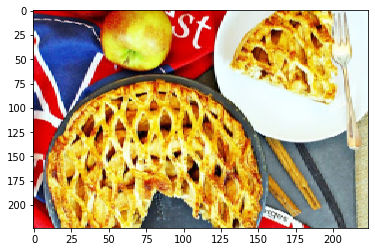

In [4]:
plt.imshow(trX[0],aspect="auto")
plt.show()

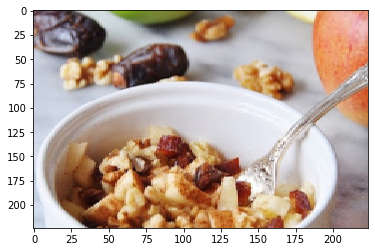

In [5]:
plt.imshow(teX[2],aspect="auto")
plt.show()

# Convert dataset to float arrays

In [6]:
trainX=np.array(trX).astype(np.float32)
trainY=np.array(trY).astype(np.float32)
testX=np.array(teX).astype(np.float32)
testY=np.array(teY).astype(np.float32)
valX=np.array(vX).astype(np.float32)
valY=np.array(vY).astype(np.float32)

In [7]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape, valX.shape, valY.shape)

(1676, 224, 224, 3) (1676, 10) (511, 224, 224, 3) (511, 10) (544, 224, 224, 3) (544, 10)


# Normalize

In [8]:
MEAN = np.mean(trainX, axis = (0,1,2))
STD = np.std(trainX, axis = (0,1,2))

In [9]:
# Take mean of all 3 channels and subtract from all images
for i in range(3):
    trainX[:, :, :, i] = (trainX[:, :, :, i] - MEAN[i]) / STD[i]
    testX[:, :, :, i] = (testX[:, :, :, i] - MEAN[i]) / STD[i]
    valX[:, :, :, i] = (valX[:, :, :, i] - MEAN[i]) / STD[i]

In [10]:
def F1_score(y_true, y_pred):
    return f1_score(y_true, y_pred, average='samples')

class ComputeF1(Callback):
    
    def __init__(self):
        self.best_f1 = -1
        
    def on_epoch_end(self, epoch, logs={}):
        val_pred = np.round(self.model.predict(self.validation_data[0]))
        val_f1 = f1_score(self.validation_data[1], val_pred, average='samples')
        print('Validation Average F1 Score: ', val_f1)
        
        if val_f1 > self.best_f1:
            print('Better F1 Score, Saving model...')
            self.model.save('model.h5')
            self.best_f1 = val_f1

In [11]:
img = Input(shape = (224, 224, 3))
model = ResNet50(include_top=False,  weights='imagenet',  input_tensor=img, input_shape=None, pooling='avg')

In [12]:
final_layer = model.layers[-1].output

dense_layer_1 = Dense(128, activation = 'relu')(final_layer)
output_layer = Dense(10, activation = 'sigmoid')(dense_layer_1)

model = Model(input = img, output = output_layer)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy' , metrics = ['accuracy'])

D:\Workdir\conda_env\default\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


In [14]:
f1_score_callback = ComputeF1()
model.fit(trainX, trainY, batch_size = 10, epochs = 10, validation_data = (valX, valY), callbacks = [f1_score_callback])

Train on 1676 samples, validate on 544 samples
Epoch 1/10
1676/1676 [==============================] - 69s 41ms/step - loss: 0.5708 - accuracy: 0.7122 - val_loss: 0.6579 - val_accuracy: 0.6768
Validation Average F1 Score:  0.3762298669467787
Better F1 Score, Saving model...
Epoch 2/10
1676/1676 [==============================] - 65s 39ms/step - loss: 0.5562 - accuracy: 0.7258 - val_loss: 6.7535 - val_accuracy: 0.7195
Validation Average F1 Score:  0.49255952380952384
Better F1 Score, Saving model...
Epoch 3/10
1676/1676 [==============================] - 66s 39ms/step - loss: 0.5409 - accuracy: 0.7372 - val_loss: 0.6792 - val_accuracy: 0.6974
Validation Average F1 Score:  0.5183940242763773
Better F1 Score, Saving model...
Epoch 4/10
1676/1676 [==============================] - 67s 40ms/step - loss: 0.5328 - accuracy: 0.7372 - val_loss: 0.7600 - val_accuracy: 0.6857
Validation Average F1 Score:  0.5196982959850607
Better F1 Score, Saving model...
Epoch 5/10
1676/1676 [==================

# Metrics

In [17]:
score = F1_score(testY, model.predict(testX).round())
print('F1 Score =', score)

F1 Score = 0.5739166899636567


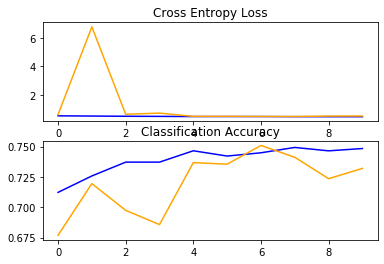

In [25]:
from matplotlib import *
history = model.history.history

pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(history['loss'], color='blue', label='train')
pyplot.plot(history['val_loss'], color='orange', label='test')
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(history['accuracy'], color='blue', label='train')
pyplot.plot(history['val_accuracy'], color='orange', label='test')

# Prediction

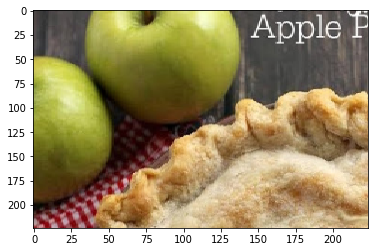

In [44]:
plt.imshow(teX[0],aspect="auto")
plt.show()

In [41]:
img = np.expand_dims(testX[0], axis=0)
prediction = np.round(model.predict(img)[0])

In [42]:
labels = [categories[idx] for idx, current_prediction in enumerate(prediction) if current_prediction == 1]

print('Prediction:', labels)

Prediction: ['mains', 'carbs', 'protein']
